In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import smooth, system_matrix_1d
from fem_assembly import assembly_1d

In [2]:
def restrict(x, sparse=False):
    """Applies the restriction operator to vector x. 

    Parameters
    ----------
    x : numpy.array
        vector on finer grid

    Returns
    ------- 
    numpy.array
        vector on coarse grid
    """
    n = x.shape[0]
    nr = int((n-1)/2)
    R = np.zeros((nr, n))
    R[:,0] = 0.5
    R[:,1] = 1
    R[:,2] = 0.5

    # Roll rows of R
    r = np.arange(0, 2*R.shape[0], 2)
    rows, column_indices = np.ogrid[:R.shape[0], :R.shape[1]]
    r[r < 0] += R.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    R = R[rows, column_indices]
    x_restricted =  np.matmul(R, x)

    return x_restricted

In [3]:
def interpolate(x, sparse=False):
    """Applies the interpolation operator to vector x

    Parameters
    ----------
    x : numpy.array
        vector on coarse grid

    Returns
    ------- 
    numpy.array
        vector on fine grid
    """
    # Pad with zeros
    x_padded = np.concatenate(([0], x, [0]))
    ni = 2*x.shape[0]+1
    I = np.zeros((ni, x_padded.shape[0]))
    I[::2,0:2] = [0.5, 0.5]
    I[1::2,0] = 1

    # Roll rows of I
    r = np.zeros(I.shape[0]+1)
    r[::2] = np.arange((r.shape[0])/2)
    r[1::2] = np.arange(r.shape[0]/2)
    r = r[1:]

    for k in range(r.shape[0]):
        I[k,:] = np.roll(I[k,:], int(r[k]))

    return np.matmul(I, x_padded)

In [4]:
def P(i, f):
    """Generate the problem for 1-dimensional discrete Poisson equation

    Parameters
    ----------
    i : int
        Number of unknowns will be 2**i - 1
        
    f : function
        The load function

    Returns
    -------
    numpy.array
        System matrix  
    numpy.array
        right-hand side
    numpy.array
        grid
    """
    number_of_points = 2**i + 1
    t = np.linspace(0, 1, number_of_points)
    T = system_matrix_1d(i)
    b = f(t[1:-1])
    return T, b, t[1:-1]

In [5]:
def P_fem(i, f):
    """Generate the problem for 1-dimensional discrete Poisson equation with dirichlet 
    boundary conditions u(0)=u(1)=0, discretized
    by the finite element method.

    Parameters
    ----------
    i : int
        Number of unknowns will be 2**i - 1
        
    f : function
        The load function

    Returns
    -------
    numpy.array
        System matrix  
    numpy.array
        right-hand side
    numpy.array
        grid
    """
    # Define nodes and edges of the fem discretization
    N_n = 2**i + 1
    N_e = N_n - 1
    nodes = np.linspace(0, 1, N_n)
    elem = np.vstack((range(N_e), range(1, N_e+1))).T

    # Assemble the system and account for boundary conditions
    A, b = assembly_1d(f, nodes, elem)
    T = A[1:N_e, 1:N_e]
    b = b[1:N_e]

    return T, b, nodes[1:N_e]

In [6]:
# Multigrid V-cycle
def MGV(b, x, i, iter_smooth=1):
    """Recursive Multigrid V-cycle algorithm

    Parameters
    ----------
    b_i : numpy.array
        right-hand side of problem P(i), fine grid
        
    x_i : numpy.array
        approximate solution of problem P(i), fine grid

    Returns
    -------
    numpy.array
        solution to the problem P(i)
    """
    T, _, _ = P_fem(i, f)
    
    if i == 1:
        #print("MGV called with i = 1")
        x = np.linalg.solve(T, b)
        return x
    else:
        #print("MGV called with i = ", i)
        # Smoothen the approximate solution
        x = smooth(x=x, A=T, b=b, n_iter=iter_smooth)
        
        # Calculate residual
        r = np.dot(T, x) - b
        
        # Restrict the residual to coarser grid
        r = restrict(x=r)
        
        # Solve the correction term d, initial guess at 0
        x0 = np.zeros_like(r)
        d = MGV(b=r, x=x0, i=i-1)
        
        # Interpolate to finer grid
        d = interpolate(d)
        
        # Make the correction and smoothen some more
        x = x - d
        x = smooth(x=x, A=T, b=b, n_iter=iter_smooth)
        return x
    

# Full Multigrid
def FMG(f, m, iter_smooth=1):
    """Full multigrid algorithm for
    
    Parameters
    ----------
    f : function
        right hand side of Poisson problem to be solved

    m : int
        maximum discretization level (2^m + 1 nodes)

    Returns
    -------
    xs : list
        solutions x at each level of discretization

    bs : list
        load vectors for each level of discretization

    ts : list
        the nodes at each level of discretization
    """
    T, b, t = P_fem(1, f)
    x = np.linalg.solve(T, b)
    xs = []
    bs = []
    ts = []
    xs.append(x)
    bs.append(b)
    ts.append(t)
    for i in range(2, m):
        x_in = interpolate(x)
        _, b_in, t_in = P_fem(i, f)
        x = MGV(b_in, x_in, i)
        xs.append(x)
        bs.append(b_in)
        ts.append(t_in)
    return xs, bs, ts

In [7]:
def f(t):
    return np.ones_like(t) * 8

In [8]:
class PoissonProblem1D:
    def __init__(self, f):
        self.f = f
        self.u = lambda t: -4*t**2+4*t
        
    def solve_fmg(self, m):
        self.xs, self.bs, self.ts = FMG(f=self.f, m=m)
        
    def plot_correct_solution(self):
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1])
    
    def plot_fmg_solution(self):
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1])
        
    def plot_fmg_solution_error(self):
        plt.figure()
        plt.plot(self.ts[-1], self.xs[-1] - self.u(self.ts[-1]))

In [9]:
poisson = PoissonProblem1D(f=f)

In [10]:
poisson.solve_fmg(16)

# Solutions

In [89]:
#poisson.xs

# Grids

In [93]:
#poisson.ts

In [94]:
#poisson.plot_correct_solution()

In [95]:
#poisson.plot_fmg_solution()

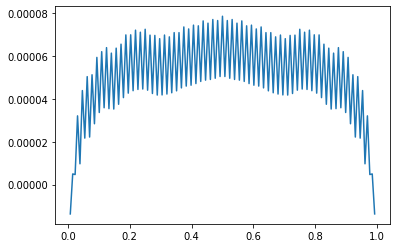

In [96]:
poisson.plot_fmg_solution_error()

In [ ]:
# Analyze errors

In [19]:
i

14

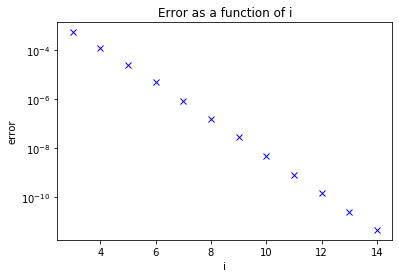

In [30]:
errs = []
i_s = list(range(3, 15))
for i in i_s:
    t = poisson.ts[i]
    h = t[0]
    ut = poisson.u(t)
    ufmgi = poisson.xs[i]
    err_i = np.sqrt(np.sum(((ufmgi - ut)*h)**2))
    errs.append(err_i)

# Plot errors

plt.figure()
plt.title('Error as a function of i')
plt.xlabel('i')
plt.ylabel('error')
plt.semilogy(i_s, errs, 'bx')
plt.savefig('err_i.png')

# Timing

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


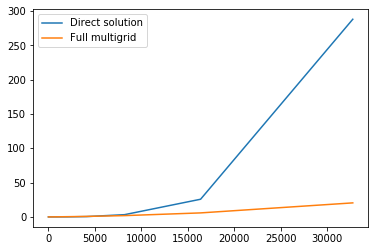

In [19]:
import time

ms = np.array(range(1,16))
ns = 2**ms + 1
times_naive = []
times_mg = []

# Iterate over problem sizes
for i in ms:
    print(i)
    # Time naive solution
    A, b, _ = P_fem(i, f)
    start = time.time()
    np.linalg.solve(A, b)
    end = time.time()
    times_naive.append(end - start)

    # Time full multigrid solution
    start = time.time()
    poisson.solve_fmg(i)
    end = time.time()
    times_mg.append(end - start)

plt.figure()
plt.plot(ns, times_naive, label="Direct solution")
plt.plot(ns, times_mg, label="Full multigrid")
plt.legend()
plt.show()

In [3]:
# Solution operator

In [45]:
# ###############################
# # Test solution operator
# ###############################

# Correct solution
def u(t):
    return -4*t**2+4*t

# RHS
def f(t):
    return np.ones_like(t)*8
    
i = 6
n = 2**i-1
t = np.linspace(0.0, 1.0, 2**i+1)[1:-1]

# System matrix and RHS
A = system_matrix_1d(i)
b = f(t)

# Correct solution
ut = u(t)

# Initial guess
x0 = np.zeros_like(b)
x0 = ut + (np.random.random(size=ut.shape)-0.5)*1.0 + np.sin(4*np.pi*t)*0.1

# Allocate array for solutions
N = 50001
uk = np.zeros((N, ut.shape[0]))
uk[0,:] = x0

for k in range(1, N):
    uk[k,:] = smooth(uk[k-1,:], A, b)

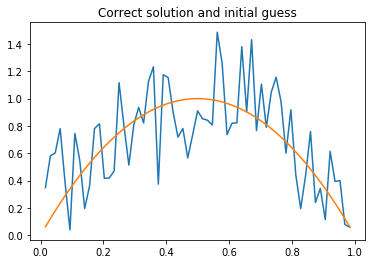

In [47]:
plt.figure()
plt.title("Correct solution and initial guess")
plt.plot(t, uk[0,:])
plt.plot(t, ut)
plt.show()

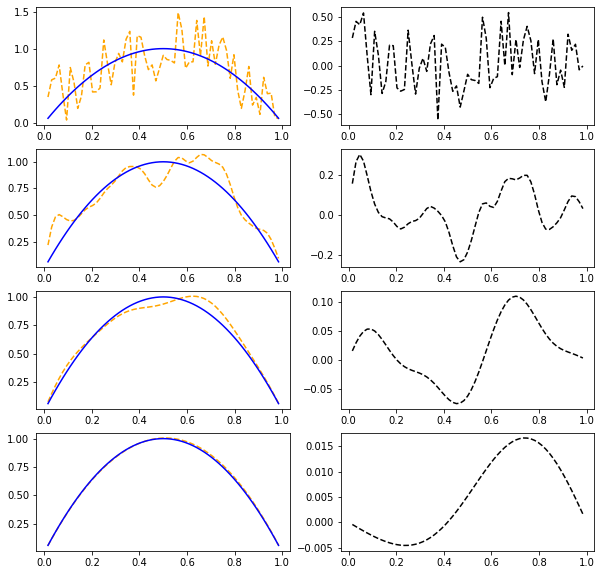

In [77]:
def plot_jacobi_iteration(u, ut, ii, filename=None):
    # Plot
    
    fig, axes = plt.subplots(len(ii), 2, figsize=(10,10))

    for k, i in enumerate(ii):
        # Error
        err0 = uk[i,:] - ut
        
        # Plot
        axes[k][0].plot(t, uk[i,:], color='orange', linestyle='--')
        axes[k][0].plot(t, ut, color='blue')
        axes[k][1].plot(t, uk[i,:] - ut, color='black', linestyle='--')

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)
    
plot_jacobi_iteration(u, ut, [0, 5, 50, 500], "smoothing_errors.png")#, "smoothing_i_{}".format(0))